<a href="https://colab.research.google.com/github/Jeonyujeong/RottenFruitsModel/blob/master/Fruits_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruits-classifier for NOOBS
https://www.kaggle.com/akhileshdkapse/fruit-quality-classifier-for-noobs

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujeong","key":"6609c0162e2974336e4324d9e87e3610"}'}

In [ ]:
!ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

100% 3.57G/3.58G [00:52<00:00, 80.8MB/s]
100% 3.58G/3.58G [00:52<00:00, 72.8MB/s]


In [ ]:
!ls

fruits-fresh-and-rotten-for-classification.zip	kaggle.json  sample_data


In [ ]:
!unzip fruits-fresh-and-rotten-for-classification.zip

In [ ]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from keras.utils  import to_categorical
import pickle

In [ ]:
def load_rand():
    X=[]
    dir_path='/content/dataset/train'
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(100,100))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X
    

In [ ]:
X=load_rand()

100%|██████████| 6/6 [00:00<00:00, 36.03it/s]

rottenbanana
freshoranges
rottenapples
freshbanana
freshapples
rottenoranges


In [ ]:
X=np.array(X)
X.shape

(36, 100, 100, 3)

In [ ]:
def show_subpot(X,title=False,Y=None):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(40,60))
        list_fruits=['rottenoranges', 'rottenapples', 'freshbanana', 'freshoranges', 'rottenbanana', 'freshapples']
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            if title==False:
                ax[i//6][i%6].set_title(list_fruits[i//6])
            elif title and Y is not None:
                ax[i//6][i%6].set_title(Y[i])
        plt.show()
    else:
        print('Cannot plot')

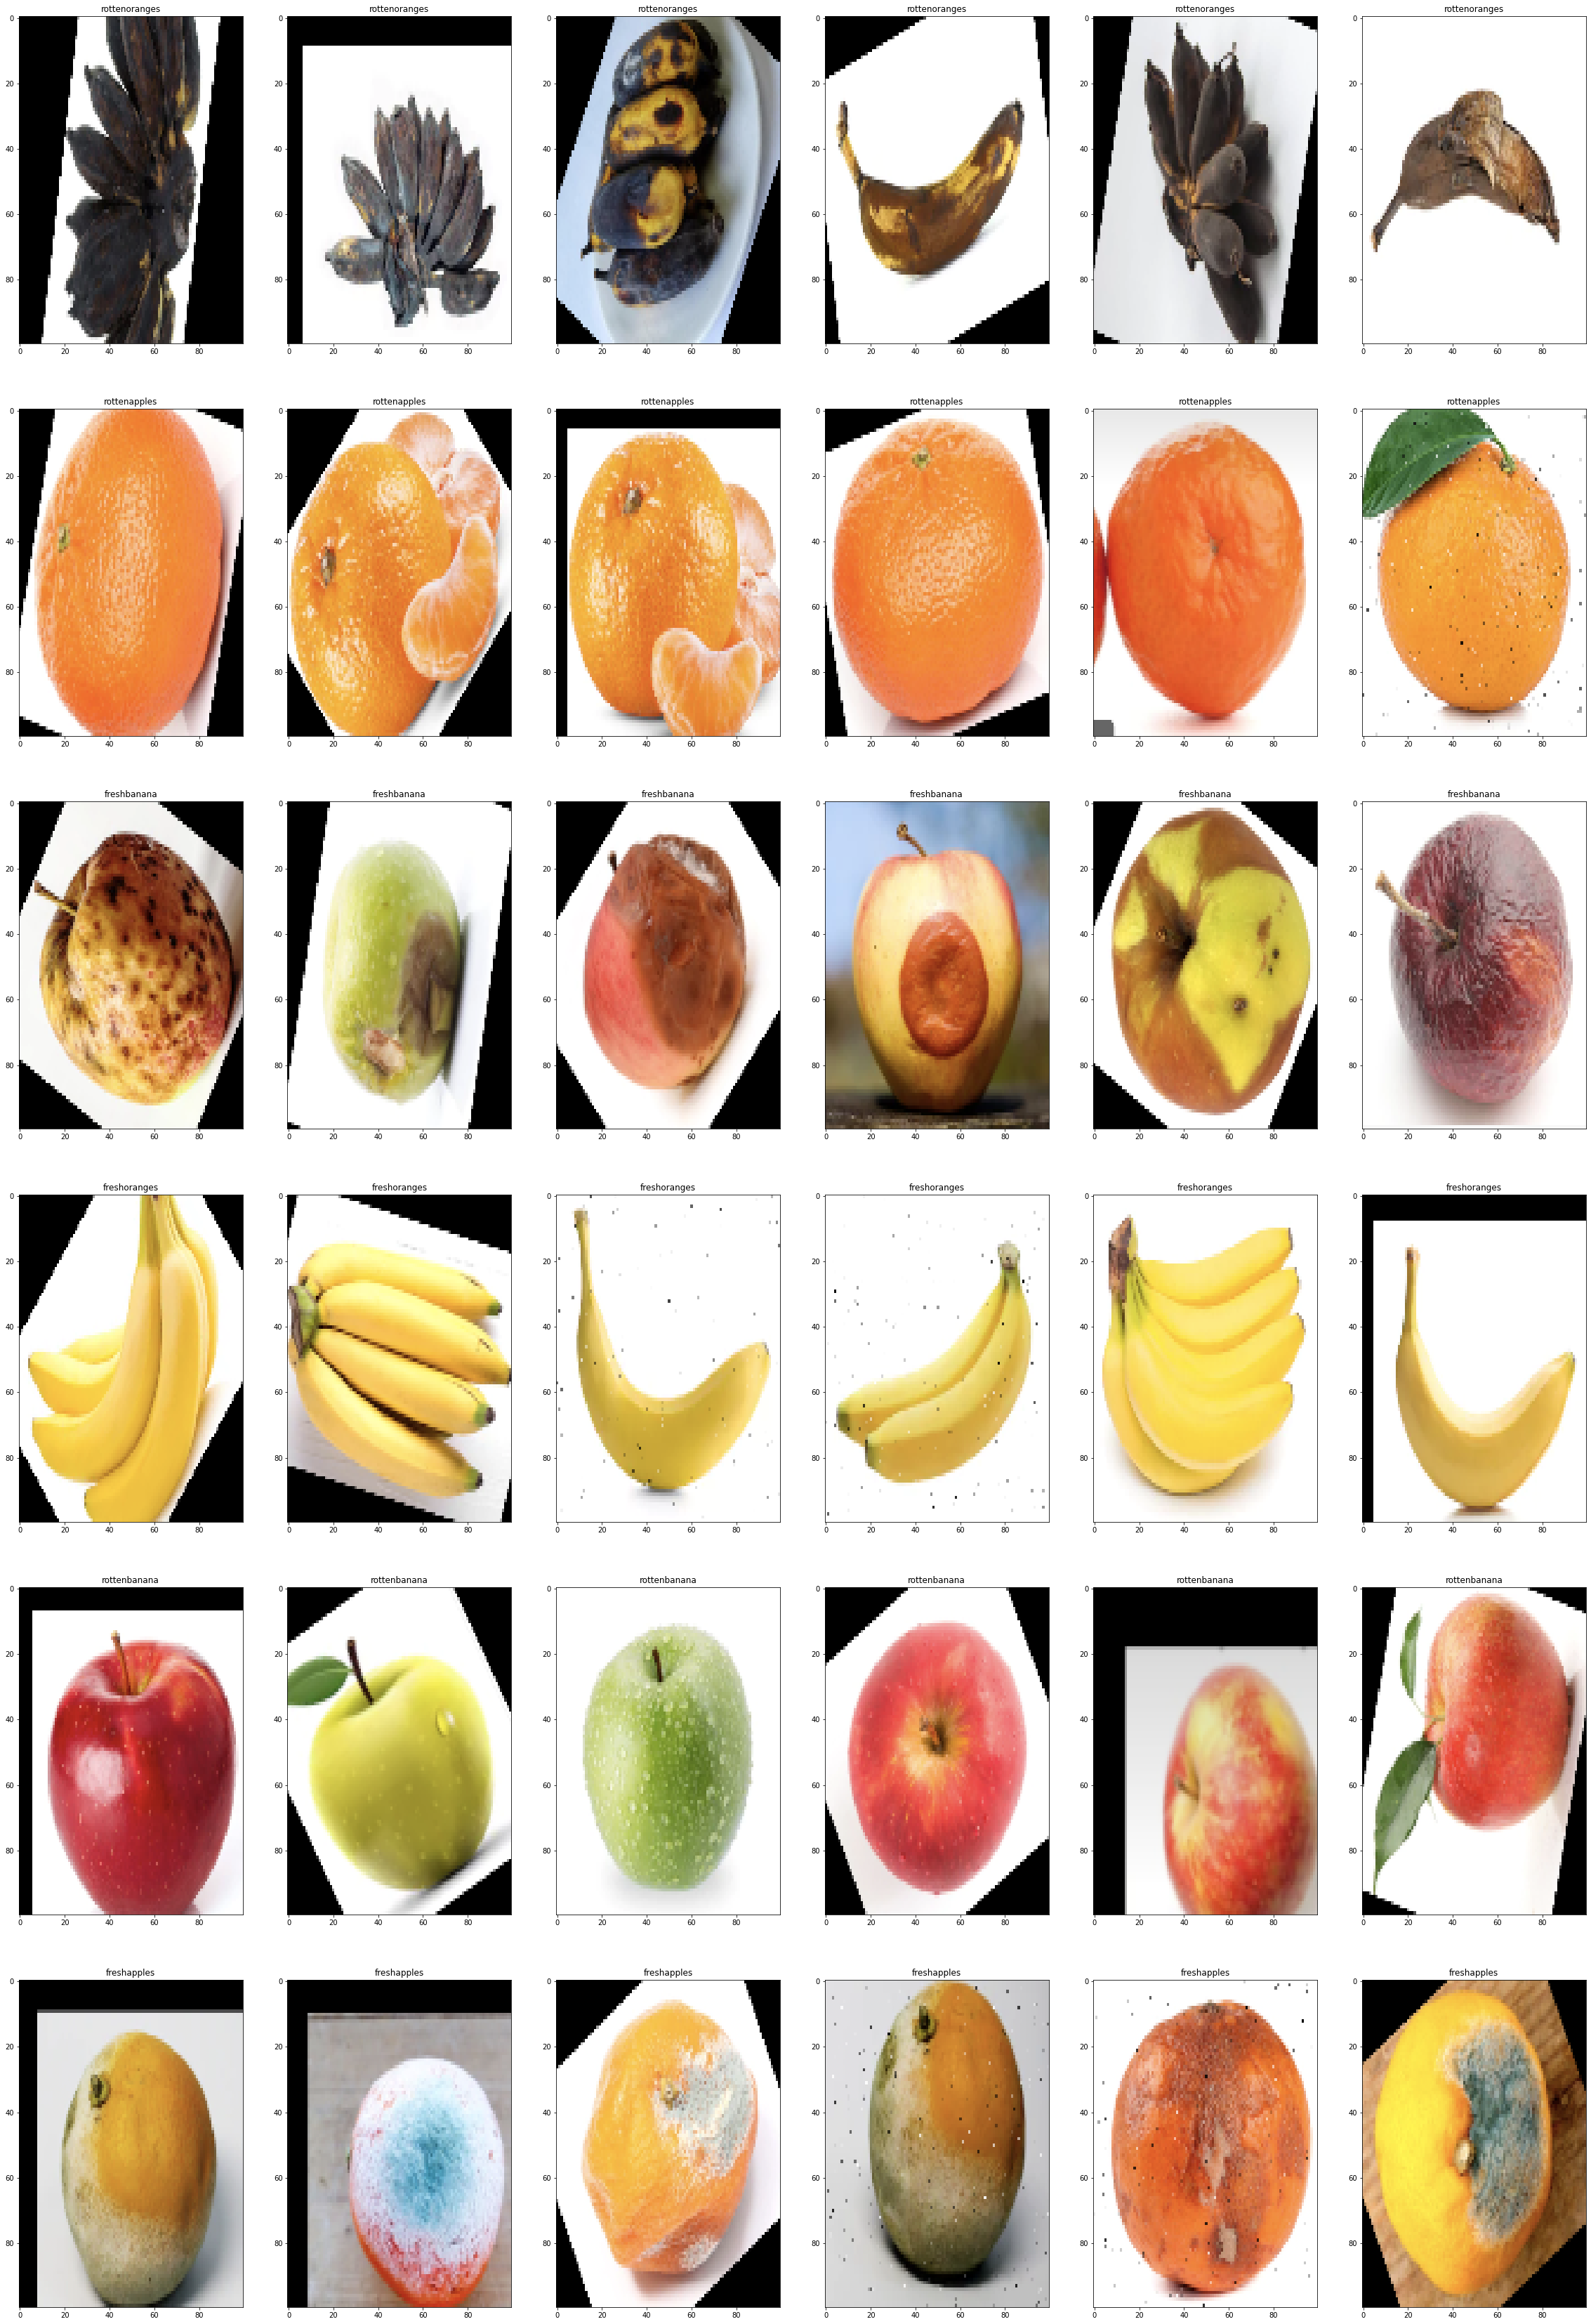

In [ ]:
show_subpot(X)

In [ ]:
del X

# Rotten vs Fresh

In [ ]:
def load_rottenvsfresh():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('/content/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('/content/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [ ]:
X,Y=load_rottenvsfresh()

100%|██████████| 10901/10901 [00:00<00:00, 1267699.22it/s]

Shuffling your data.....


In [ ]:
Y=np.array(Y)
X=np.array(X)
y_ser=pd.Series(Y)
y_ser.value_counts()

1    6161
0    4740
dtype: int64

In [ ]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('/content/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('/content/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y            

In [ ]:
X_val,Y_val=load_rottenvsfresh_valset()

100%|██████████| 2698/2698 [00:00<00:00, 833485.47it/s]

Shuffling your data.....


In [ ]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

## 모델 정의

In [ ]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [ ]:
import tensorflow as tf

In [ ]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/rotten.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [ ]:
X=X/255.0
X_val=X_val/255.0

In [ ]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 50,
                 callbacks=[check_point])

Epoch 1/50
546/546 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8853
Epoch 00001: val_loss improved from inf to 638.29712, saving model to /content/rotten.h5
546/546 [==============================] - 569s 1s/step - loss: 0.2979 - accuracy: 0.8853 - val_loss: 638.2971 - val_accuracy: 0.4318
Epoch 2/50
546/546 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9200
Epoch 00002: val_loss improved from 638.29712 to 84.46190, saving model to /content/rotten.h5
546/546 [==============================] - 567s 1s/step - loss: 0.2032 - accuracy: 0.9200 - val_loss: 84.4619 - val_accuracy: 0.5052
Epoch 3/50
546/546 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9435
Epoch 00003: val_loss improved from 84.46190 to 74.77135, saving model to /content/rotten.h5
546/546 [==============================] - 568s 1s/step - loss: 0.1493 - accuracy: 0.9435 - val_loss: 74.7714 - val_accuracy: 0.6205
Epoch 4/50
546/546 [================

KeyboardInterrupt: ignored

In [ ]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [ ]:
model.evaluate(X_val,Y_val)

135/135 [==============================] - 36s 263ms/step - loss: 70.0168 - accuracy: 0.7168


[70.01683807373047, 0.7168272733688354]

In [ ]:
model.save('/content/rottenvsfresh')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/rottenvsfresh/assets


In [ ]:
!zip -r rottenvsfresh.zip rottenvsfresh

  adding: rottenvsfresh/ (stored 0%)
  adding: rottenvsfresh/assets/ (stored 0%)
  adding: rottenvsfresh/saved_model.pb (deflated 90%)
  adding: rottenvsfresh/variables/ (stored 0%)
  adding: rottenvsfresh/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: rottenvsfresh/variables/variables.index (deflated 74%)


In [ ]:
from google.colab import files
files.download('rottenvsfresh.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('/content/rottenvsfresh.h5')

In [ ]:
from keras.models import Model, load_model

In [ ]:
# new_model=load_model('/content/rottenvsfresh.h5')
new_model=load_model('/content/rotten.h5')
new_model.evaluate(X_val,Y_val)

85/85 [==============================] - 35s 407ms/step - loss: 4.8332 - accuracy: 0.7050


[4.833168983459473, 0.70496666431427]

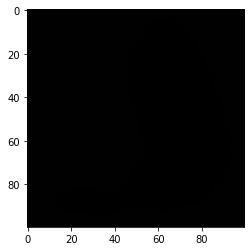

In [ ]:
plt.imshow(X_val[0])

In [ ]:
model.predict(X_val[0].reshape(1,100,100,3))

array([[0.999992]], dtype=float32)

In [ ]:
show_subpot(X_val[-36*11:-36*10])

In [ ]:
model.predict_classes(X_val[-36*11:-36*10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1]], dtype=int32)

# 과일 카테고리 분류

In [ ]:
def load_fruits_data():
    quality=['apples', 'banana','oranges']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('/content/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('/content/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[2] in cata:
            path_main=os.path.join('/content/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2])
        
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 

In [ ]:
def load_fruits_train_data():
    quality=['apples', 'banana','oranges']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('/content/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('/content/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[2] in cata:
            path_main=os.path.join('/content/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2])
        
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 

In [ ]:
X_val,Y_val=load_fruits_data()

100%|██████████| 2698/2698 [00:00<00:00, 669877.00it/s]

Shuffling your data.....


In [ ]:
X,Y=load_fruits_train_data()

100%|██████████| 10901/10901 [00:00<00:00, 1343819.30it/s]

Shuffling your data.....


In [ ]:
X=np.array(X)
X_val=np.array(X_val)

In [ ]:
X.shape,X_val.shape

((10901, 100, 100, 3), (2698, 100, 100, 3))

In [ ]:
X=X/255.0
X_val=X_val/255.0

In [ ]:
Y=to_categorical(Y)
Y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
Y_test=to_categorical(Y_val)
Y_val=np.array(Y_val)

In [ ]:
Y.shape,Y_test.shape, Y_val.shape

((10901, 3), (2698, 3), (2698,))

## 모델 정의

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

In [ ]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/fruit_cata.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [ ]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_test),epochs= 10,
                 callbacks=[check_point])

Epoch 1/10
546/546 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9215
Epoch 00001: val_loss improved from inf to 1.58445, saving model to /content/fruit_cata.h5
546/546 [==============================] - 515s 943ms/step - loss: 0.2207 - accuracy: 0.9215 - val_loss: 1.5844 - val_accuracy: 0.4956
Epoch 2/10
546/546 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9362
Epoch 00002: val_loss improved from 1.58445 to 0.34948, saving model to /content/fruit_cata.h5
546/546 [==============================] - 514s 942ms/step - loss: 0.1843 - accuracy: 0.9362 - val_loss: 0.3495 - val_accuracy: 0.8621
Epoch 3/10
546/546 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9447
Epoch 00003: val_loss did not improve from 0.34948
546/546 [==============================] - 516s 945ms/step - loss: 0.1504 - accuracy: 0.9447 - val_loss: 0.4417 - val_accuracy: 0.8643
Epoch 4/10
546/546 [==============================] - ETA: 0s - loss: 

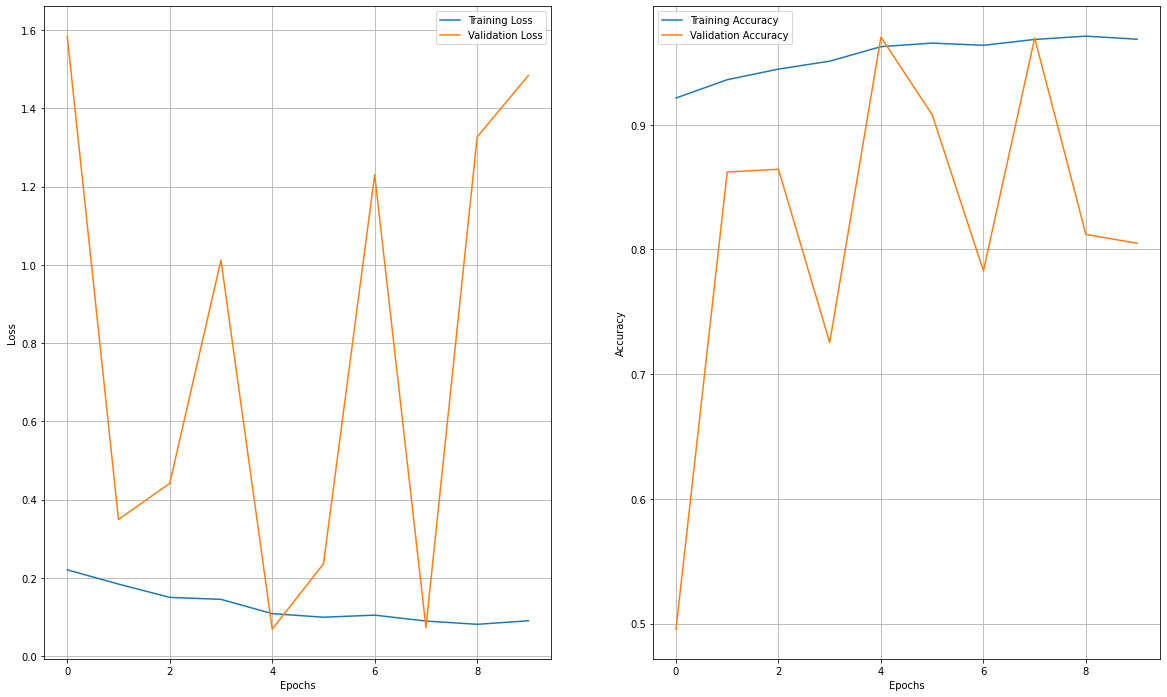

In [ ]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [ ]:
model.save('/content/fruit_cata')
model.save('/content/fruit_cata.h5')

INFO:tensorflow:Assets written to: /content/fruit_cata/assets


In [ ]:
!zip -r fruit_cata.zip fruit_cata
!zip model_h5.zip 'fruit_cata.h5' 'rotten.h5'

  adding: fruit_cata/ (stored 0%)
  adding: fruit_cata/assets/ (stored 0%)
  adding: fruit_cata/saved_model.pb (deflated 90%)
  adding: fruit_cata/variables/ (stored 0%)
  adding: fruit_cata/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: fruit_cata/variables/variables.index (deflated 75%)
  adding: fruit_cata.h5 (deflated 6%)
  adding: rotten.h5 (deflated 9%)


In [ ]:
files.download('fruit_cata.zip')
files.download('model_h5.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model=load_model('fruit_cata.h5')

In [ ]:
model.evaluate(X,Y)

341/341 [==============================] - 131s 383ms/step - loss: 1.5054 - accuracy: 0.8005


[1.505384087562561, 0.8004770278930664]

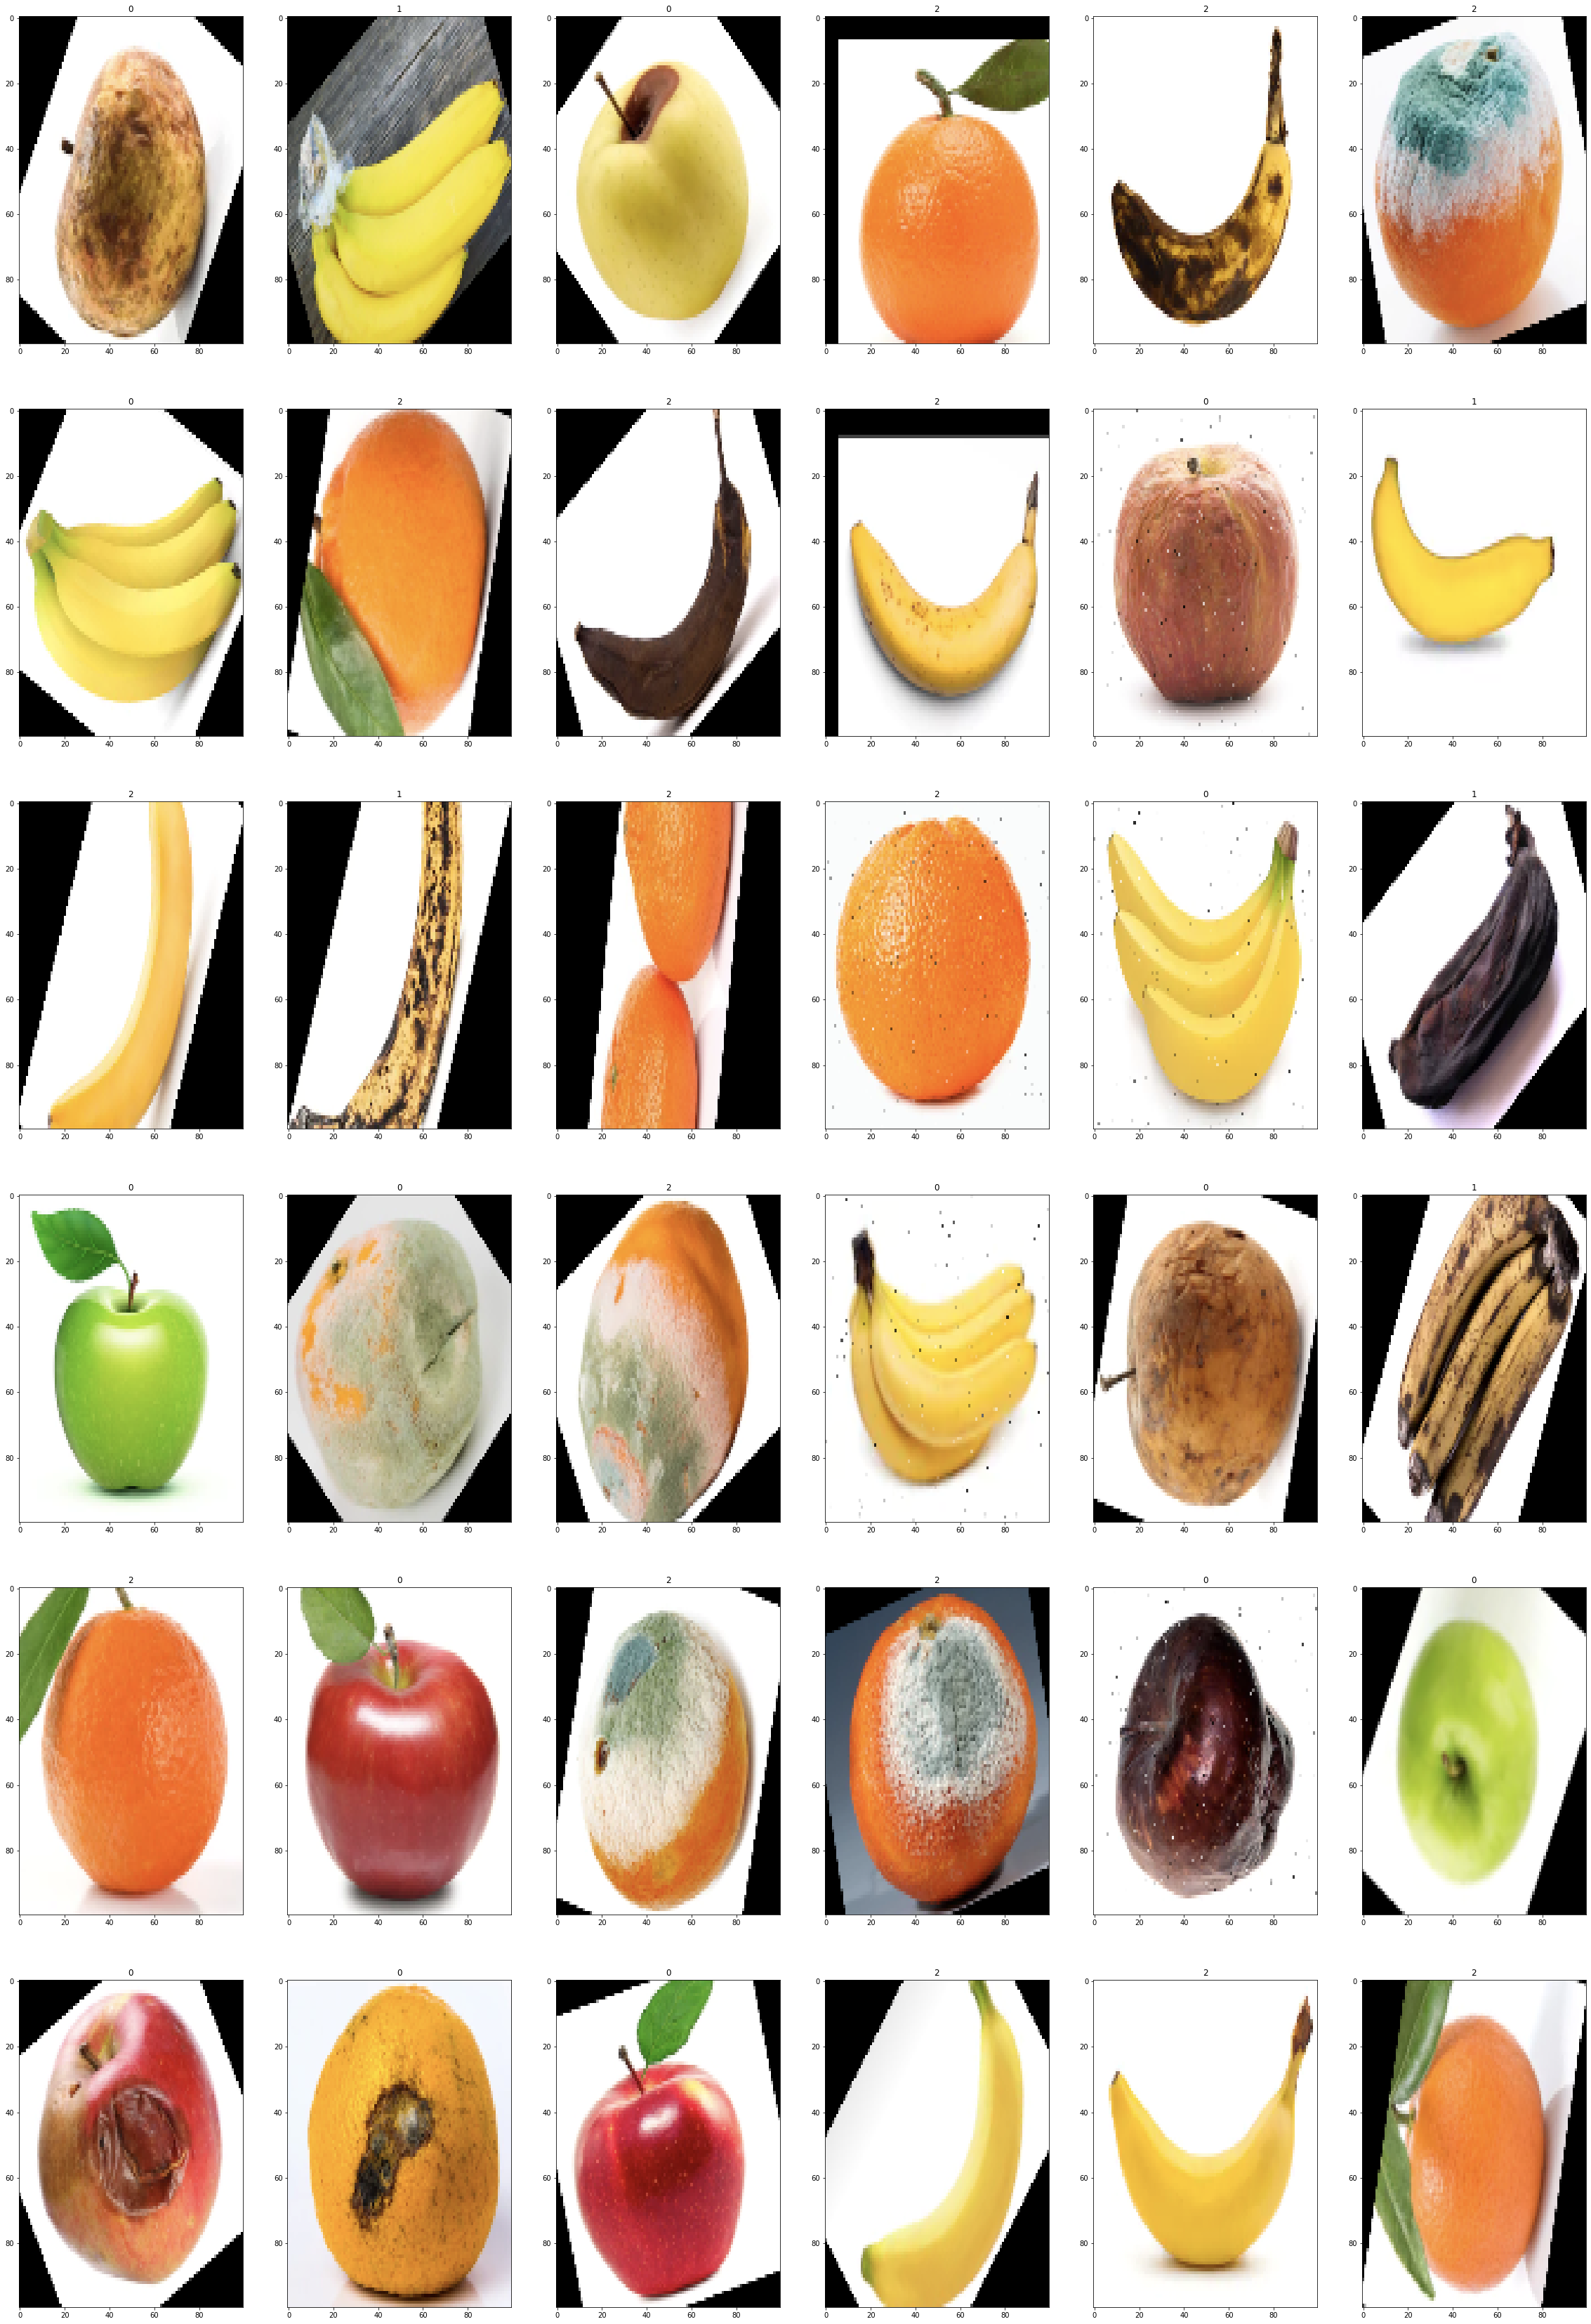

In [ ]:
show_subpot(X_val[:36],title=True,Y=model.predict_classes(X_val[:36]))

In [ ]:
model.predict_classes(X_val[:36])

array([0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0,
       0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2])